## CNN - BGR

## CNN - RGB

## CNN - RGB & Data Preprocessed

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/RGB & 데이터 전처리 O'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_bgr = cv2.imread(image_path)
            
            # 노이즈 제거
            image_bgr = cv2.fastNlMeansDenoisingColored(image_bgr, None, 10, 10, 7, 21)
            
            # YUV 컬로 포맷으로 변환
            image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
            # 히스토그램 평활화 적용
            image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
            # #RGB로 변환
            image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
            
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

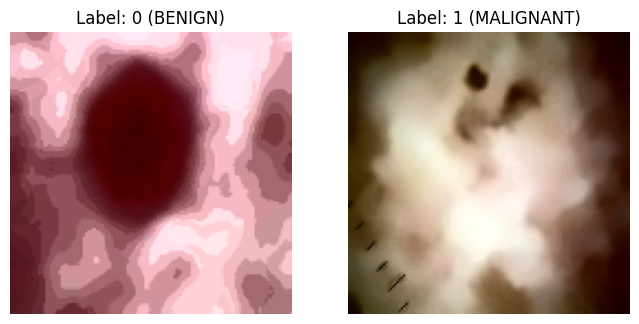

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(128, 128, 3)
sample_image_1 = X[y == 1][0].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 입력층
        MaxPooling2D((2, 2)),   # Maxpooling
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),  # 가장 큰 특징을 모아서 1차원 배열로 변환
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # sigmoid는 이진 분류를 위한 활성화함수(단일클래스)
    ])
    return model

In [ ]:
input_shape = (128, 128, 3)  # grayscale: 1, rgb: 3
model = create_simple_cnn(input_shape)  # 모델 생성 (input_shape에 맞게)

model.compile(optimizer='adam', # Optimizer: adam 사용
              loss='binary_crossentropy', # sigmoid를 사용했기 때문에 binary loss 사용
              metrics=['accuracy']) # 평가 metrics: accuracy

early_stopping = EarlyStopping(   # 특정 조건을 만족하면 stop을 하도록 조건을 추가
    monitor='val_loss',
    patience=10,  # 가중치 변화가 없는 지 확인하는 횟수
    verbose=1,
    mode='min',   # loss 값은 최소값으로 찾기
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(   # 가중치를 저장
    'best_CNN_model.h5',
    monitor='val_accuracy',
    mode='max',   # validation 가장 큰 값
    verbose=1,
    save_best_only=True
)

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"


2024-07-10 17:33:56.254598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 17:33:56.254875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 100352)            0         
          

In [ ]:
history = model.fit(
    X_train, y_train, # train data
    validation_data=(X_val, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=[early_stopping, model_checkpoint]  # 학습 stop 조건, 가중치 파일 저장
)

Epoch 1/50


2024-07-10 17:33:56.897589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 17:33:57.641804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6944

2024-07-10 17:34:02.930481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.75500, saving model to best_CNN_model.h5
50/50 [==============================] - 7s 73ms/step - loss: 0.6563 - accuracy: 0.6944 - val_loss: 0.4839 - val_accuracy: 0.7550
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.7825
Epoch 2: val_accuracy improved from 0.75500 to 0.77500, saving model to best_CNN_model.h5
50/50 [==============================] - 4s 78ms/step - loss: 0.4565 - accuracy: 0.7825 - val_loss: 0.4589 - val_accuracy: 0.7750
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8062
Epoch 3: val_accuracy did not improve from 0.77500
50/50 [==============================] - 4s 73ms/step - loss: 0.4382 - accuracy: 0.8062 - val_loss: 0.4560 - val_accuracy: 0.7700
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8281
Epoch 4: val_accuracy improved from 0.77500 to 0.78000, saving model to best_CNN_model.h5
50/50 [==

In [ ]:
model = tf.keras.models.load_model('best_CNN_model.h5') # 학습 후 가장 높은 성능을 보이는 가중치를 가져오기

#### Result

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:4f}")

2024-07-10 17:34:50.456888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 33ms/step - loss: 0.4602 - accuracy: 0.8050
Test Accuracy: 0.805000


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 확률값이 0.5 초과는 1로 저장할 것

5/7 [====================>.........] - ETA: 0s

2024-07-10 17:34:51.006731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 24ms/step


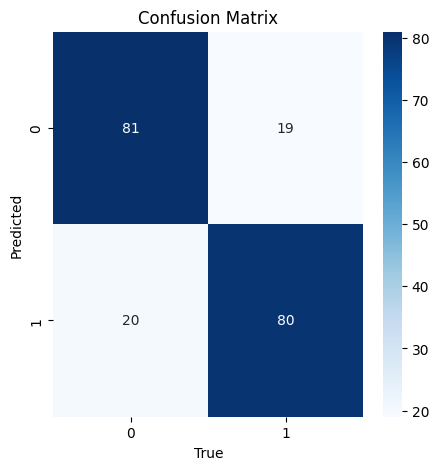

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

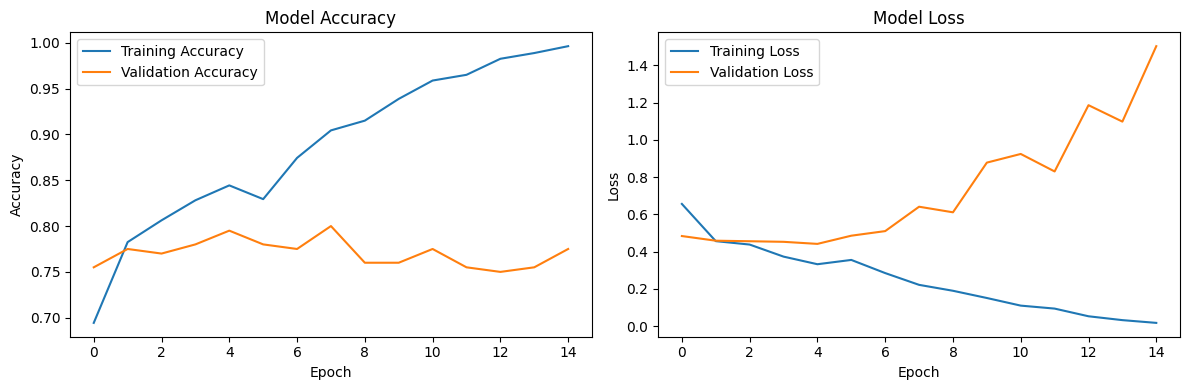

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

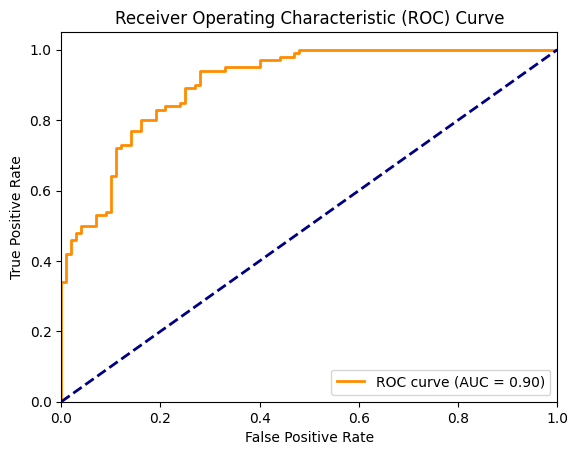

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [ ]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/RGB'

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [ ]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            
            image = cv2.imread(image_path)  # color로 이미지 데이터 받아오기
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
            image = cv2.resize(image, img_size)  # 이미지 사이즈 resize
            
            images.append(image)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [ ]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

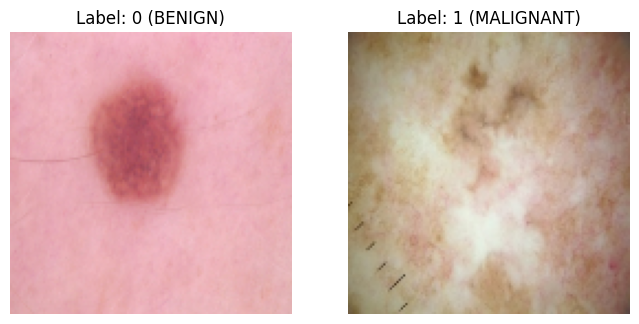

In [ ]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(128, 128, 3)
sample_image_1 = X[y == 1][0].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [ ]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [ ]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [ ]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 입력층
        MaxPooling2D((2, 2)),   # Maxpooling
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),  # 가장 큰 특징을 모아서 1차원 배열로 변환
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # sigmoid는 이진 분류를 위한 활성화함수(단일클래스)
    ])
    return model

In [ ]:
input_shape = (128, 128, 3)  # grayscale: 1, rgb: 3
model = create_simple_cnn(input_shape)  # 모델 생성 (input_shape에 맞게)

model.compile(optimizer='adam', # Optimizer: adam 사용
              loss='binary_crossentropy', # sigmoid를 사용했기 때문에 binary loss 사용
              metrics=['accuracy']) # 평가 metrics: accuracy

early_stopping = EarlyStopping(   # 특정 조건을 만족하면 stop을 하도록 조건을 추가
    monitor='val_loss',
    patience=10,  # 가중치 변화가 없는 지 확인하는 횟수
    verbose=1,
    mode='min',   # loss 값은 최소값으로 찾기
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(   # 가중치를 저장
    'best_CNN_model.h5',
    monitor='val_accuracy',
    mode='max',   # validation 가장 큰 값
    verbose=1,
    save_best_only=True
)

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 17:40:52.617423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 17:40:52.618132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 100352)            0

In [ ]:
history = model.fit(
    X_train, y_train, # train data
    validation_data=(X_val, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=[early_stopping, model_checkpoint]  # 학습 stop 조건, 가중치 파일 저장
)

Epoch 1/50


2024-07-10 17:40:53.381490: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 17:40:53.701772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.6400

2024-07-10 17:40:57.825029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.65000, saving model to best_CNN_model.h5
50/50 [==============================] - 5s 85ms/step - loss: 0.6876 - accuracy: 0.6400 - val_loss: 0.5738 - val_accuracy: 0.6500
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.7663
Epoch 2: val_accuracy did not improve from 0.65000
50/50 [==============================] - 3s 62ms/step - loss: 0.4729 - accuracy: 0.7663 - val_loss: 0.6416 - val_accuracy: 0.6400
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.7638
Epoch 3: val_accuracy improved from 0.65000 to 0.76500, saving model to best_CNN_model.h5
50/50 [==============================] - 3s 69ms/step - loss: 0.4837 - accuracy: 0.7638 - val_loss: 0.5405 - val_accuracy: 0.7650
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.7831
Epoch 4: val_accuracy did not improve from 0.76500
50/50 [==============================] - 3s 64ms

In [ ]:
model = tf.keras.models.load_model('best_CNN_model.h5') # 학습 후 가장 높은 성능을 보이는 가중치를 가져오기

#### Result

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:4f}")

1/7 [===>..........................] - ETA: 1s - loss: 0.3811 - accuracy: 0.7812

2024-07-10 17:42:07.938105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 40ms/step - loss: 0.4358 - accuracy: 0.7950
Test Accuracy: 0.795000


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 확률값이 0.5 초과는 1로 저장할 것

5/7 [====================>.........] - ETA: 0s

2024-07-10 17:42:08.484225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 47ms/step


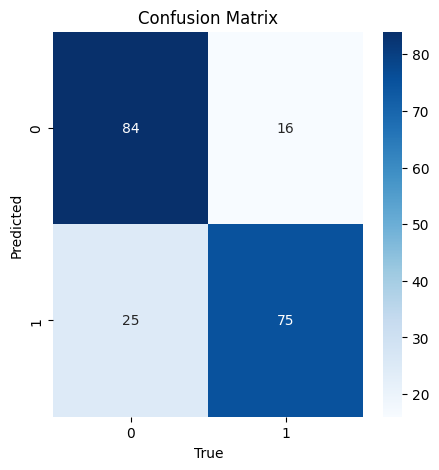

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

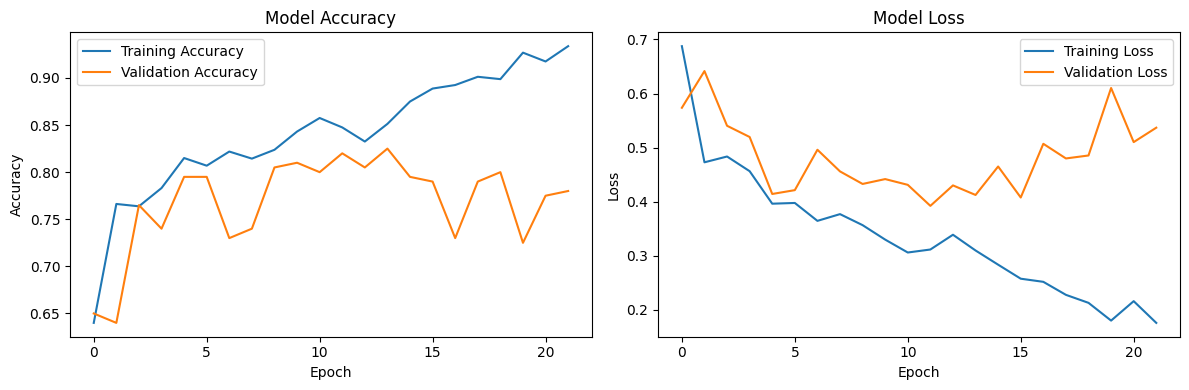

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

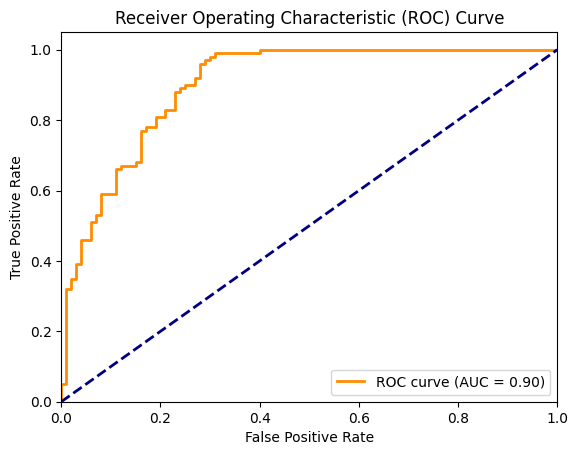

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### 환경구성

In [1]:
%pwd

'/Users/junghyun/Desktop/Python/DeepNoid/BGR'

In [2]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# [MacOS] GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [4]:
# [MacOS] 그래픽카드 메모리 정리 메소드
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

#### 데이터 로드

In [5]:
def load_and_preprocess_data(base_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = ['BENIGN', 'MALIGNANT'] # 카테고리

    for category in categories:
        class_num = categories.index(category)  # benign: 0, malignant: 1
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)

        for idx in range(1000):
            image_path = os.path.join(base_path, base_files[idx])
            image_rgb = cv2.imread(image_path)
            image_rgb = cv2.resize(image_rgb, img_size)
            images.append(image_rgb)
            labels.append(class_num)

    # 정규화
    images = np.array(images).astype('float32') / 255.0
    return images, np.array(labels)

In [6]:
base_dir = '../datasets/skin-cancer' # 데이터 경로
X, y = load_and_preprocess_data(base_dir) # 2000장 데이터 로드

(-0.5, 127.5, 127.5, -0.5)

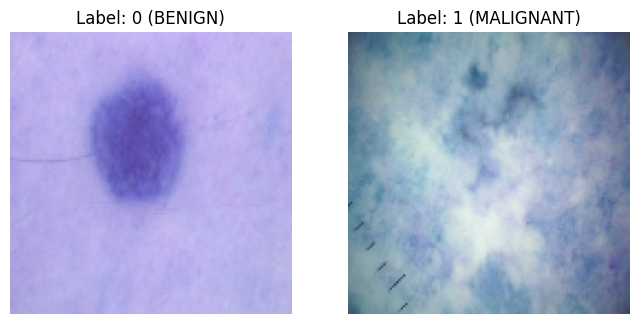

In [7]:
# 라벨이 0인 이미지와 1인 이미지 각각 하나씩 가져오기
sample_image_0 = X[y == 0][0].reshape(128, 128, 3)
sample_image_1 = X[y == 1][0].reshape(128, 128, 3)

# 샘플 이미지 시각화
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sample_image_0)
axes[0].set_title("Label: 0 (BENIGN)")
axes[0].axis('off')

axes[1].imshow(sample_image_1)
axes[1].set_title("Label: 1 (MALIGNANT)")
axes[1].axis('off')

#### 데이터 분할

In [8]:
def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

In [10]:
print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (1600, 128, 128, 3), 레이블 형태: (1600,)
검증 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)
테스트 데이터 형태: (200, 128, 128, 3), 레이블 형태: (200,)


#### 모델 생성

In [11]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 입력층
        MaxPooling2D((2, 2)),   # Maxpooling
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),  # 가장 큰 특징을 모아서 1차원 배열로 변환
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # sigmoid는 이진 분류를 위한 활성화함수(단일클래스)
    ])
    return model

In [12]:
input_shape = (128, 128, 3)  # grayscale: 1, rgb: 3
model = create_simple_cnn(input_shape)  # 모델 생성 (input_shape에 맞게)

model.compile(optimizer='adam', # Optimizer: adam 사용
              loss='binary_crossentropy', # sigmoid를 사용했기 때문에 binary loss 사용
              metrics=['accuracy']) # 평가 metrics: accuracy

early_stopping = EarlyStopping(   # 특정 조건을 만족하면 stop을 하도록 조건을 추가
    monitor='val_loss',
    patience=10,  # 가중치 변화가 없는 지 확인하는 횟수
    verbose=1,
    mode='min',   # loss 값은 최소값으로 찾기
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(   # 가중치를 저장
    'best_CNN_model.h5',
    monitor='val_accuracy',
    mode='max',   # validation 가장 큰 값
    verbose=1,
    save_best_only=True
)

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 17:46:05.999708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 17:46:06.000380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 100352)            0

In [13]:
history = model.fit(
    X_train, y_train, # train data
    validation_data=(X_val, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=[early_stopping, model_checkpoint]  # 학습 stop 조건, 가중치 파일 저장
)

Epoch 1/50


2024-07-10 17:46:06.855665: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 17:46:07.276009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.6800

2024-07-10 17:46:11.545184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.78500, saving model to best_CNN_model.h5
50/50 [==============================] - 5s 90ms/step - loss: 0.7306 - accuracy: 0.6800 - val_loss: 0.4868 - val_accuracy: 0.7850
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.7850
Epoch 2: val_accuracy improved from 0.78500 to 0.79500, saving model to best_CNN_model.h5
50/50 [==============================] - 3s 67ms/step - loss: 0.4768 - accuracy: 0.7850 - val_loss: 0.4394 - val_accuracy: 0.7950
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.7962
Epoch 3: val_accuracy did not improve from 0.79500
50/50 [==============================] - 4s 76ms/step - loss: 0.4248 - accuracy: 0.7962 - val_loss: 0.4336 - val_accuracy: 0.7800
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.7944
Epoch 4: val_accuracy did not improve from 0.79500
50/50 [==============================] - 3s 61ms

In [14]:
model = tf.keras.models.load_model('best_CNN_model.h5') # 학습 후 가장 높은 성능을 보이는 가중치를 가져오기

#### Result

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:4f}")

1/7 [===>..........................] - ETA: 1s - loss: 0.4809 - accuracy: 0.7812

2024-07-10 17:47:04.695900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 93ms/step - loss: 0.4294 - accuracy: 0.8100
Test Accuracy: 0.810000


In [16]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 확률값이 0.5 초과는 1로 저장할 것

4/7 [================>.............] - ETA: 0s

2024-07-10 17:47:05.574800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 29ms/step


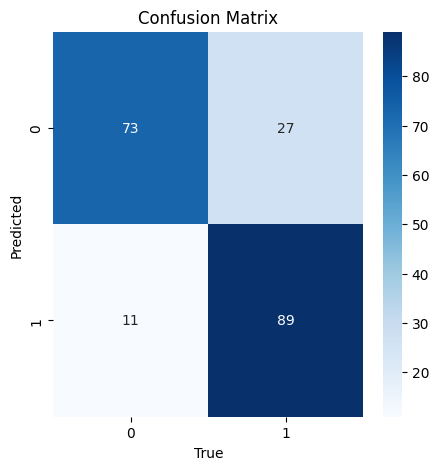

In [17]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

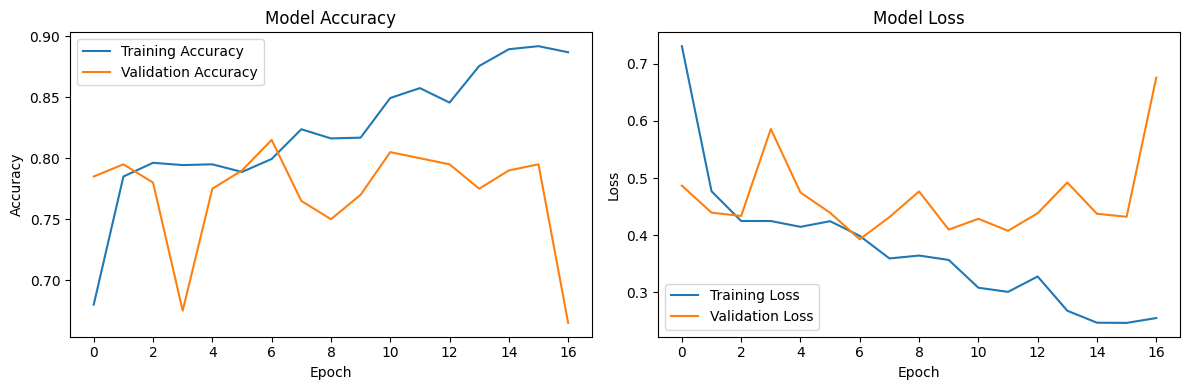

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

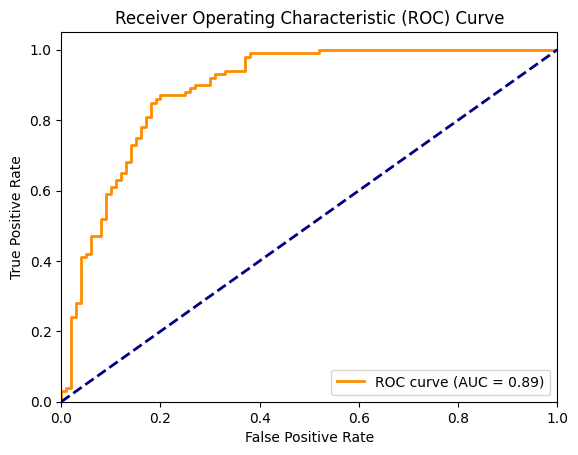

In [19]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()